<a href="https://colab.research.google.com/github/brochowski/ekantorwidget/blob/main/brochowski_excercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade scikit-learn

In [4]:
import numpy as np
import pandas as pd
import sklearn

sklearn.__version__

'1.2.2'

In [10]:
df = pd.read_csv('/content/drive/MyDrive/Bufor/export.csv', sep=';')
dta_cp = df.copy()
dta_cp.columns = dta_cp.iloc[0]
dta_cp = dta_cp.iloc[1:]
dta_cp = dta_cp.iloc[:, 2:]

new_column_names = ['DATE', 'EX_BUYING', 'EX_SELLING', 'SPREAD']
dta_cp.columns = new_column_names

dta_cp['EX_BUYING'] = dta_cp['EX_BUYING'].str.replace(',', '.').astype(float)  # Konwertuj kolumnę EX_BUYING na float
dta_cp['EX_SELLING'] = dta_cp['EX_SELLING'].str.replace(',', '.').astype(float)  # Konwertuj kolumnę EX_SEELING na float
dta_cp['DATE'] = dta_cp['DATE'].apply(lambda x: x.split('.')[0])

dta_cp['SPREAD'] = dta_cp['EX_SELLING'] - dta_cp['EX_BUYING']


from datetime import datetime

def konwertuj_na_date(data_str):
    maska = "%Y-%m-%dT%H:%M:%S"
    data = datetime.strptime(data_str, maska)
    return data


dta_cp['DATE'] = dta_cp['DATE'].apply(konwertuj_na_date)

dta_cp['DAY_OF_WEEK'] = dta_cp['DATE'].apply(lambda x: x.weekday())
dta_cp['HOUR_NO'] = dta_cp['DATE'].apply(lambda x: int(x.strftime('%H')))
dta_cp['MONTH_NO'] = dta_cp['DATE'].apply(lambda x: x.month)


##print(dta_cp.columns)

#print(dta_cp.head())
#dta_cp.info()

,DATE,EX_BUYING,EX_SELLING,SPREAD,DAY_OF_WEEK,HOUR_NO,MONTH_NO
2,2023-06-15 23:13:05,4.0380,4.1036,0.0656,3,23,6
3,2023-06-15 23:14:24,4.0375,4.1046,0.0671,3,23,6
4,2023-06-15 23:16:48,4.0382,4.1009,0.0627,3,23,6
5,2023-06-15 23:16:55,4.0383,4.1020,0.0637,3,23,6
6,2023-06-15 23:26:48,4.0385,4.1008,0.0623,3,23,6
...,...,...,...,...,...,...,...
2137,2023-07-11 05:49:35,4.0046,4.0609,0.0563,1,5,7
2138,2023-07-11 06:05:04,4.0040,4.0604,0.0564,1,6,7
2139,2023-07-11 06:20:09,4.0043,4.0607,0.0564,1,6,7
2140,2023-07-11 06:35:13,4.0034,4.0599,0.0565,1,6,7


In [3]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
dta_cp[['EX_BUYING', 'EX_SELLING', 'SPREAD']] = scaler.fit_transform(dta_cp[['EX_BUYING', 'EX_SELLING', 'SPREAD']])
#dta_cp

In [24]:
dta_cp['SPREAD_CAT'] = pd.cut(x=dta_cp.SPREAD, bins=3, labels=['small','medium','high'])
#dta_cp

In [11]:
hours_bins = [0, 6, 12, 18, 24]
hours_labels = ['night', 'morning', 'afternoon', 'evening']

dta_cp['TIME_OF_DAY'] = pd.cut(x=dta_cp.HOUR_NO, bins=hours_bins, labels=hours_labels)
#dta_cp

In [13]:
qmonth_bins = [0, 8, 15, 22, 32]
qmonth_labels = ['first', 'second', 'third', 'forth']

# Dodanie kolumny 'TIME_OF_DAY' z odpowiednimi etykietami
dta_cp['QUARTER_OF_MONTH'] = pd.cut(dta_cp['DATE'].dt.day, bins=qmonth_bins, labels=qmonth_labels)
print(dta_cp)

                    DATE  EX_BUYING  EX_SELLING  SPREAD  DAY_OF_WEEK  HOUR_NO  \
2    2023-06-15 23:13:05     4.0380      4.1036  0.0656            3       23   
3    2023-06-15 23:14:24     4.0375      4.1046  0.0671            3       23   
4    2023-06-15 23:16:48     4.0382      4.1009  0.0627            3       23   
5    2023-06-15 23:16:55     4.0383      4.1020  0.0637            3       23   
6    2023-06-15 23:26:48     4.0385      4.1008  0.0623            3       23   
...                  ...        ...         ...     ...          ...      ...   
2137 2023-07-11 05:49:35     4.0046      4.0609  0.0563            1        5   
2138 2023-07-11 06:05:04     4.0040      4.0604  0.0564            1        6   
2139 2023-07-11 06:20:09     4.0043      4.0607  0.0564            1        6   
2140 2023-07-11 06:35:13     4.0034      4.0599  0.0565            1        6   
2141 2023-07-11 06:36:53     4.0030      4.0594  0.0564            1        6   

      MONTH_NO TIME_OF_DAY 

In [14]:
import statsmodels.api as sm

def get_trend_label(value):
    if value > 0:
        return 'increase'
    elif value < 0:
        return 'decrease'
    else:
        return 'stable'

# Reset the index of the DataFrame
dta_cp.reset_index(drop=True, inplace=True)

dta_cp['trend_selling'] = 'stable'
dta_cp['trend_buying'] = 'stable'

for i in range(1, len(dta_cp)):
    prev_ex_buying = dta_cp.at[i - 1, 'EX_BUYING']
    prev_ex_selling = dta_cp.at[i - 1, 'EX_SELLING']
    curr_ex_buying = dta_cp.at[i, 'EX_BUYING']
    curr_ex_selling = dta_cp.at[i, 'EX_SELLING']
    slope = curr_ex_buying - prev_ex_buying
    slopee = curr_ex_selling - prev_ex_selling
    dta_cp.at[i, 'trend_buying'] = get_trend_label(slope)
    dta_cp.at[i, 'trend_selling'] = get_trend_label(slopee)
dta_cp

,DATE,EX_BUYING,EX_SELLING,SPREAD,DAY_OF_WEEK,HOUR_NO,MONTH_NO,TIME_OF_DAY,QUARTER_OF_MONTH,trend_selling,trend_buying
0,2023-06-15 23:13:05,4.0380,4.1036,0.0656,3,23,6,evening,second,stable,stable
1,2023-06-15 23:14:24,4.0375,4.1046,0.0671,3,23,6,evening,second,increase,decrease
2,2023-06-15 23:16:48,4.0382,4.1009,0.0627,3,23,6,evening,second,decrease,increase
3,2023-06-15 23:16:55,4.0383,4.1020,0.0637,3,23,6,evening,second,increase,increase
4,2023-06-15 23:26:48,4.0385,4.1008,0.0623,3,23,6,evening,second,decrease,increase
...,...,...,...,...,...,...,...,...,...,...,...
2135,2023-07-11 05:49:35,4.0046,4.0609,0.0563,1,5,7,night,second,decrease,decrease
2136,2023-07-11 06:05:04,4.0040,4.0604,0.0564,1,6,7,night,second,decrease,decrease
2137,2023-07-11 06:20:09,4.0043,4.0607,0.0564,1,6,7,night,second,increase,increase
2138,2023-07-11 06:35:13,4.0034,4.0599,0.0565,1,6,7,night,second,decrease,decrease


In [ ]:
dta_cp.describe()

In [ ]:
dta_cp.describe().T

In [15]:
import plotly.express as px

df_plotly = dta_cp.reset_index()
px.line(dta_cp, 'DATE', 'EX_BUYING', width=1000, height=500, title='WYKRESIK_1')

In [16]:
px.line(dta_cp, 'DATE', 'SPREAD', width=1000, height=500, title='WYKRESIK_3')

In [ ]:
px.line(dta_cp, 'DATE', 'trend_selling', width=1000, height=500, title='WYKRESIK_3')

In [25]:
dummy_spread = pd.get_dummies(dta_cp['SPREAD_CAT'],drop_first=True, prefix='spread')
dta_cp = pd.concat([dta_cp, dummy_spread], axis=1)
dta_cp = dta_cp.drop('SPREAD_CAT', axis=1)

In [22]:
dummy_trend = pd.get_dummies(dta_cp['trend_selling'],drop_first=True, prefix='selling_trend')
dta_cp = pd.concat([dta_cp, dummy_trend], axis=1)
dta_cp = dta_cp.drop('trend_selling', axis=1)

In [27]:
dummy_tod = pd.get_dummies(dta_cp['TIME_OF_DAY'],drop_first=True, prefix='TOD')
dta_cp = pd.concat([dta_cp, dummy_tod], axis=1)
dta_cp = dta_cp.drop('TIME_OF_DAY', axis=1)

In [32]:
dummy_qom = pd.get_dummies(dta_cp['QUARTER_OF_MONTH'],drop_first=True, prefix='Q_MTH')
dta_cp = pd.concat([dta_cp, dummy_qom], axis=1)
dta_cp = dta_cp.drop('QUARTER_OF_MONTH', axis=1)

In [35]:
porządki
dta_cp = dta_cp.drop('trend_buying', axis=1)
dta_cp = dta_cp.drop('SPREAD', axis=1)
dta_cp = dta_cp.drop('DATE', axis=1)
dta_cp = dta_cp.drop('spread_medium', axis=1)
dta_cp = dta_cp.drop('spread_high', axis=1)
dta_cp = dta_cp.drop('HOUR_NO', axis=1)

In [36]:
dta_cp

,EX_BUYING,EX_SELLING,DAY_OF_WEEK,HOUR_NO,MONTH_NO,selling_trend_increase,selling_trend_stable,TOD_morning,TOD_afternoon,TOD_evening,Q_MTH_second,Q_MTH_third,Q_MTH_forth
0,4.0380,4.1036,3,23,6,0,1,0,0,1,1,0,0
1,4.0375,4.1046,3,23,6,1,0,0,0,1,1,0,0
2,4.0382,4.1009,3,23,6,0,0,0,0,1,1,0,0
3,4.0383,4.1020,3,23,6,1,0,0,0,1,1,0,0
4,4.0385,4.1008,3,23,6,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2135,4.0046,4.0609,1,5,7,0,0,0,0,0,1,0,0
2136,4.0040,4.0604,1,6,7,0,0,0,0,0,1,0,0
2137,4.0043,4.0607,1,6,7,1,0,0,0,0,1,0,0
2138,4.0034,4.0599,1,6,7,0,0,0,0,0,1,0,0


In [37]:
#sprawdzamy duplikaty
dta_cp[dta_cp.duplicated()]

,EX_BUYING,EX_SELLING,DAY_OF_WEEK,HOUR_NO,MONTH_NO,selling_trend_increase,selling_trend_stable,TOD_morning,TOD_afternoon,TOD_evening,Q_MTH_second,Q_MTH_third,Q_MTH_forth
74,4.0351,4.1295,5,0,6,0,1,0,0,0,0,1,0
78,4.0351,4.1295,5,7,6,0,1,1,0,0,0,1,0
79,4.0351,4.1295,5,7,6,0,1,1,0,0,0,1,0
81,4.0351,4.1295,5,8,6,0,1,1,0,0,0,1,0
82,4.0351,4.1295,5,8,6,0,1,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013,4.0331,4.0895,6,21,7,0,1,0,0,1,1,0,0
2014,4.0331,4.0895,6,21,7,0,1,0,0,1,1,0,0
2015,4.0331,4.0895,6,21,7,0,1,0,0,1,1,0,0
2017,4.0331,4.0895,6,22,7,0,1,0,0,1,1,0,0


In [38]:
#usuwamy duplikaty
dta_cp = dta_cp.drop_duplicates()
dta_cp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1695 entries, 0 to 2139
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   EX_BUYING               1695 non-null   float64
 1   EX_SELLING              1695 non-null   float64
 2   DAY_OF_WEEK             1695 non-null   int64  
 3   HOUR_NO                 1695 non-null   int64  
 4   MONTH_NO                1695 non-null   int64  
 5   selling_trend_increase  1695 non-null   uint8  
 6   selling_trend_stable    1695 non-null   uint8  
 7   TOD_morning             1695 non-null   uint8  
 8   TOD_afternoon           1695 non-null   uint8  
 9   TOD_evening             1695 non-null   uint8  
 10  Q_MTH_second            1695 non-null   uint8  
 11  Q_MTH_third             1695 non-null   uint8  
 12  Q_MTH_forth             1695 non-null   uint8  
dtypes: float64(2), int64(3), uint8(8)
memory usage: 92.7 KB


In [46]:
#wyświetlamy podstawowe dane dataframe'a
dta_cp.describe()

,EX_BUYING,EX_SELLING,DAY_OF_WEEK,MONTH_NO,selling_trend_increase,selling_trend_stable,TOD_morning,TOD_afternoon,TOD_evening,Q_MTH_second,Q_MTH_third,Q_MTH_forth
count,1695.000000,1695.000000,1695.000000,1695.000000,1695.000000,1695.000000,1695.000000,1695.000000,1695.000000,1695.000000,1695.000000,1695.000000
mean,4.045538,4.102585,2.329794,6.391150,0.411799,0.172861,0.256637,0.253687,0.208260,0.090265,0.269027,0.334513
std,0.020570,0.025348,1.812759,0.488152,0.492304,0.378239,0.436906,0.435249,0.406183,0.286646,0.443585,0.471959
min,4.003000,4.042500,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.035100,4.089500,1.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.042100,4.097700,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.056200,4.113700,4.000000,7.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,4.112700,4.194300,6.000000,7.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [40]:
#czy są nulle?
dta_cp.isnull().sum()

EX_BUYING                 0
EX_SELLING                0
DAY_OF_WEEK               0
HOUR_NO                   0
MONTH_NO                  0
selling_trend_increase    0
selling_trend_stable      0
TOD_morning               0
TOD_afternoon             0
TOD_evening               0
Q_MTH_second              0
Q_MTH_third               0
Q_MTH_forth               0
dtype: int64

In [41]:
#jak zbadac rozkład zmiennej - tu na przykład HOUR_NO
dta_cp.HOUR_NO.value_counts()

6     81
23    76
16    76
15    76
0     76
9     75
12    75
21    74
14    73
11    73
10    72
7     71
5     71
13    70
8     69
18    68
19    68
20    68
17    67
22    67
1     65
2     64
4     61
3     59
Name: HOUR_NO, dtype: int64

<Axes: ylabel='Frequency'>

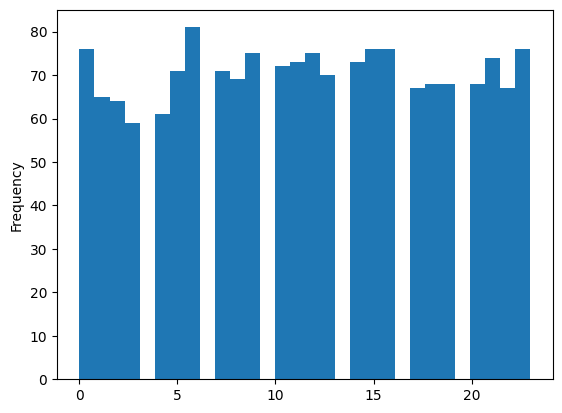

In [42]:
#można to sobie wrzucić na pie
dta_cp.HOUR_NO.plot(kind='hist', bins=30)

In [44]:
px.histogram(dta_cp, x='EX_BUYING', width=1400, height=800, nbins=50, facet_col='HOUR_NO', facet_row='DAY_OF_WEEK')

In [48]:
#badamy korelację zmiennych
corr = dta_cp.corr()
corr

,EX_BUYING,EX_SELLING,DAY_OF_WEEK,MONTH_NO,selling_trend_increase,selling_trend_stable,TOD_morning,TOD_afternoon,TOD_evening,Q_MTH_second,Q_MTH_third,Q_MTH_forth
EX_BUYING,1.000000,0.758059,0.143554,0.159358,0.052536,-0.066894,0.191697,0.102565,-0.126240,-0.253612,-0.286629,0.108598
EX_SELLING,0.758059,1.000000,0.231180,0.152641,0.027817,0.066216,-0.064117,-0.071669,0.057388,-0.249971,-0.166804,-0.000428
DAY_OF_WEEK,0.143554,0.231180,1.000000,-0.063810,-0.158883,0.479010,0.014564,0.009868,0.019709,-0.162977,-0.036990,0.096603
MONTH_NO,0.159358,0.152641,-0.063810,1.000000,-0.024620,0.017242,-0.011488,-0.011654,-0.009158,0.355026,-0.486255,-0.568269
selling_trend_increase,0.052536,0.027817,-0.158883,-0.024620,1.000000,-0.382507,-0.036043,0.030101,0.040251,-0.033488,0.003296,0.026702
selling_trend_stable,-0.066894,0.066216,0.479010,0.017242,-0.382507,1.000000,-0.061422,-0.022699,0.026819,0.008451,-0.073270,0.049562
TOD_morning,0.191697,-0.064117,0.014564,-0.011488,-0.036043,-0.061422,1.000000,-0.342569,-0.301349,-0.048387,0.024287,-0.004332
TOD_afternoon,0.102565,-0.071669,0.009868,-0.011654,0.030101,-0.022699,-0.342569,1.000000,-0.299020,-0.046436,-0.008199,0.026321
TOD_evening,-0.126240,0.057388,0.019709,-0.009158,0.040251,0.026819,-0.301349,-0.299020,1.000000,0.026042,-0.012995,-0.000256
Q_MTH_second,-0.253612,-0.249971,-0.162977,0.355026,-0.033488,0.008451,-0.048387,-0.046436,0.026042,1.000000,-0.191095,-0.223327


<Axes: >

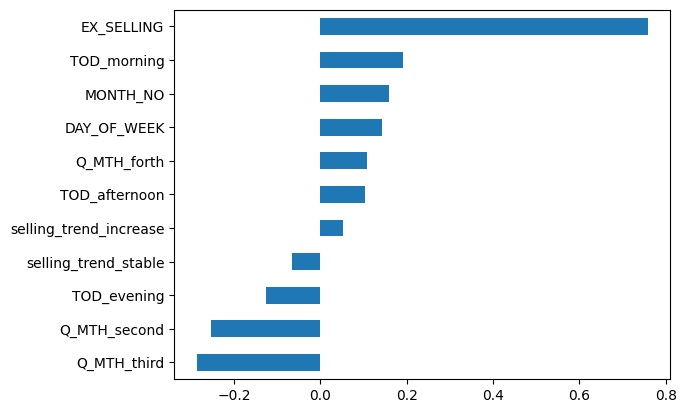

In [49]:
#dalej korelacja
dta_cp.corr()['EX_BUYING'].sort_values()[:-1].plot(kind='barh')

In [50]:
#podział zbioru danych na: DATA i TARGET
data = dta_cp.copy()
target = data.pop('EX_BUYING')
data.head()

,EX_SELLING,DAY_OF_WEEK,MONTH_NO,selling_trend_increase,selling_trend_stable,TOD_morning,TOD_afternoon,TOD_evening,Q_MTH_second,Q_MTH_third,Q_MTH_forth
0,4.1036,3,6,0,1,0,0,1,1,0,0
1,4.1046,3,6,1,0,0,0,1,1,0,0
2,4.1009,3,6,0,0,0,0,1,1,0,0
3,4.1020,3,6,1,0,0,0,1,1,0,0
4,4.1008,3,6,0,0,0,0,1,1,0,0


In [53]:
#podział danych na zbiór testowy i treningowy
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2)

print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (1356, 11)
X_test shape: (339, 11)
y_train shape: (1356,)
y_test shape: (339,)


In [54]:
#Regresja liniowa
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [55]:
#wyświetlenie score'a dla modelu
print(f'R2 score: {regressor.score(X_test, y_test):.4f}')

R2 score: 0.7475


In [56]:
#pierwsze 10 predykcji na danych testowych
y_pred = regressor.predict(X_test)
y_pred[:10]

array([4.03519717, 4.04043014, 4.0414352 , 4.0452341 , 4.03129264,
       4.05760857, 4.02253091, 4.03802351, 4.0380653 , 4.03573122])

In [59]:
# oglądamy predykcje względem wartości true ze zbioru testowego
y_true = y_test.copy();
predictions = pd.DataFrame(data={'y_true': y_true, 'y_pred': y_pred})
predictions['error'] = predictions['y_true'] - predictions['y_pred']
predictions.head()

,y_true,y_pred,error
866,4.0343,4.035197,-0.000897
1899,4.0331,4.040430,-0.007330
848,4.0417,4.041435,0.000265
1521,4.0452,4.045234,-0.000034
900,4.0265,4.031293,-0.004793


<Axes: ylabel='Frequency'>

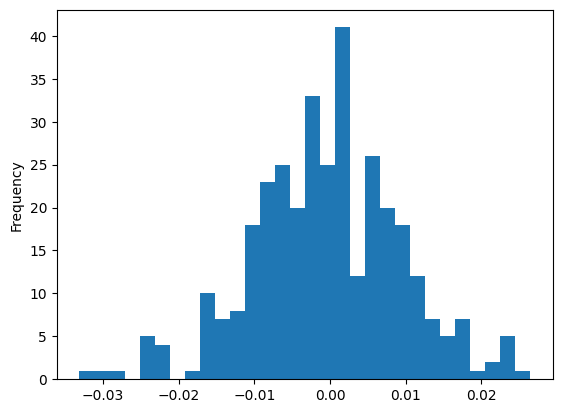

In [60]:
predictions.error.plot(kind='hist', bins=30)

In [61]:
#można sobie zobaczyć mean_square_error - taki uśredniony błąd o ile algo się myli
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_true, y_pred)
print(f'MAE wynosi: {mae:.2f}')

MAE wynosi: 0.01


In [62]:
#ile wynosi intercept (w punkcie 0)
regressor.intercept_

1.5452179527970054

In [63]:
#ile wynoszą współczynniki wielomianu
regressor.coef_

array([ 6.14230516e-01, -1.26519233e-04, -3.32800887e-03,  4.71658027e-05,
       -5.49596382e-03,  1.57198035e-02,  1.27411118e-02,  5.97695646e-04,
       -5.03382574e-03, -1.14381003e-02, -2.62040417e-03])

In [64]:
data.columns

Index(['EX_SELLING', 'DAY_OF_WEEK', 'MONTH_NO', 'selling_trend_increase',
       'selling_trend_stable', 'TOD_morning', 'TOD_afternoon', 'TOD_evening',
       'Q_MTH_second', 'Q_MTH_third', 'Q_MTH_forth'],
      dtype='object')

In [ ]:
import yfinance as yf
import plotly.express as pxx

# Pobieranie danych dla pary walut USD/PLN
df = yf.download('USDPLN=X', start='2023-06-15', end='2023-07-11', interval='1h')

# Zmiana nazwy kolumny 'USDPLN=X' na bardziej standardową
df.rename(columns={'USDPLN=X': 'Close'}, inplace=True)

# Wyświetlanie wykresu
fig = px.line(df, x=df.index, y='Close', width=1000, height=500, title='Wykres kursu USD/PLN')
fig.show()

#print(df)

In [ ]:
px.line(dta_cp, 'DATE', 'EX_SELLING', width=1000, height=500, title='WYKRESIK_2')